# Data Processing for the House Price Kaggle Competition

My work has been inspired by the following kernels:

https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python#3.-Keep-calm-and-work-smart

https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
%matplotlib inline

In [2]:
train = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/train.csv')
test = pd.read_csv('/Users/pol.molinas/Downloads/Kaggle/House Price/Data Input/test.csv')

In [3]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


## Analyse Target ##

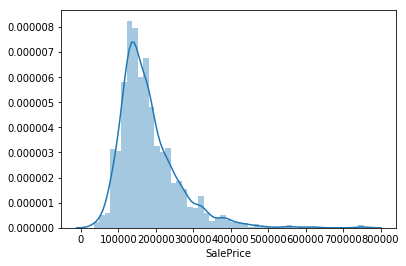

In [4]:
sns.distplot(train.SalePrice)

In [5]:
train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [6]:
train.SalePrice.skew()

1.8828757597682129

In [7]:
train.SalePrice.isna().sum()

0

In [8]:
train.SalePrice.isnull().sum()

0

SalePrice is skewed to the right, will have to be normalised.

The maximum seems to be very far from 75% percentile, shows evidence of outliers.

No 0 value

No NA or null

## Missing Data ##

In [9]:
ntrain = train.shape[0]
ntest = test.shape[0]
#y_train = train.SalePrice
all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


/Users/pol.molinas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  after removing the cwd from sys.path.


In [10]:
all_data.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,...,SaleType,ScreenPorch,Street,TotRmsAbvGrd,TotalBsmtSF,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,856,854,0,NaN,3,1Fam,TA,No,706.0,0.0,...,WD,0,Pave,8,856.0,AllPub,0,2003,2003,2008
1,1262,0,0,NaN,3,1Fam,TA,Gd,978.0,0.0,...,WD,0,Pave,6,1262.0,AllPub,298,1976,1976,2007
2,920,866,0,NaN,3,1Fam,TA,Mn,486.0,0.0,...,WD,0,Pave,6,920.0,AllPub,0,2001,2002,2008
3,961,756,0,NaN,3,1Fam,Gd,No,216.0,0.0,...,WD,0,Pave,7,756.0,AllPub,0,1915,1970,2006
4,1145,1053,0,NaN,4,1Fam,TA,Av,655.0,0.0,...,WD,0,Pave,9,1145.0,AllPub,192,2000,2000,2008


In [11]:
def check_nas():    
    sample_values = pd.DataFrame(index=all_data.columns,columns=['SampleValue'])
    for i in all_data.columns:
        sample_values.loc[i].SampleValue = all_data[i].value_counts().index[1]
    nas = pd.DataFrame(all_data.isnull().sum(),columns=['SumOfNA'])
    types = pd.DataFrame(all_data.dtypes,columns=['Type'])
    sample_values.sort_index(inplace=True)
    nas.sort_index(inplace=True)
    types.sort_index(inplace=True)
    alls=pd.concat([sample_values,nas,types],axis=1)
    return(alls[alls.SumOfNA>0].sort_values('SumOfNA',ascending=False))

In [12]:
check_nas()

,SampleValue,SumOfNA,Type
PoolQC,Gd,2909,object
MiscFeature,Gar2,2814,object
Alley,Pave,2721,object
Fence,GdPrv,2348,object
FireplaceQu,TA,1420,object
LotFrontage,80,486,float64
GarageCond,Fa,159,object
GarageQual,Fa,159,object
GarageYrBlt,2006,159,float64
GarageFinish,RFn,159,object


In [13]:
# Most of the NAs are probably because the property does not contain the specific thing (eg. No Pool)
none_feats = ['PoolQC','MiscFeature','Alley','Fence','FireplaceQu',
              'GarageFinish','GarageQual','GarageType','GarageCond',
              'BsmtFinType2','BsmtExposure','BsmtFinType1','BsmtQual',
              'BsmtCond','MasVnrType','MSZoning']
zero_feats = ['LotFrontage','GarageYrBlt','MasVnrArea']

In [14]:
for i in none_feats:
    all_data[i].fillna('None',inplace=True)

In [15]:
for i in zero_feats:
    all_data[i].fillna(0,inplace=True)

In [16]:
all_data.drop(['MasVnrArea','MasVnrType','Electrical'],axis=1,inplace=True)

In [17]:
check_nas()

,SampleValue,SumOfNA,Type
BsmtFullBath,1,2,float64
BsmtHalfBath,1,2,float64
Functional,Min2,2,object
Utilities,NoSeWa,2,object
BsmtFinSF1,24,1,float64
BsmtFinSF2,294,1,float64
BsmtUnfSF,384,1,float64
Exterior1st,MetalSd,1,object
Exterior2nd,MetalSd,1,object
GarageArea,576,1,float64


In [18]:
all_data['BsmtFullBath'].fillna(0,inplace=True)
all_data['BsmtHalfBath'].fillna(0,inplace=True)
all_data['Functional'].fillna('Typ',inplace=True)
all_data['Utilities'].fillna('AllPub',inplace=True)
all_data['BsmtFinSF1'].fillna(0,inplace=True)
all_data['BsmtFinSF2'].fillna(0,inplace=True)
all_data['BsmtUnfSF'].fillna(0,inplace=True)
all_data['Exterior1st'].fillna('VinylSd',inplace=True)
all_data['Exterior2nd'].fillna('VinylSd',inplace=True)
all_data['GarageArea'].fillna(0,inplace=True)
all_data['GarageCars'].fillna(0,inplace=True)
all_data['KitchenQual'].fillna('None',inplace=True)
all_data['SaleType'].fillna('WD',inplace=True)
all_data['TotalBsmtSF'].fillna(0,inplace=True)


In [19]:
check_nas()

,SampleValue,SumOfNA,Type


## Features Importance and Correlation

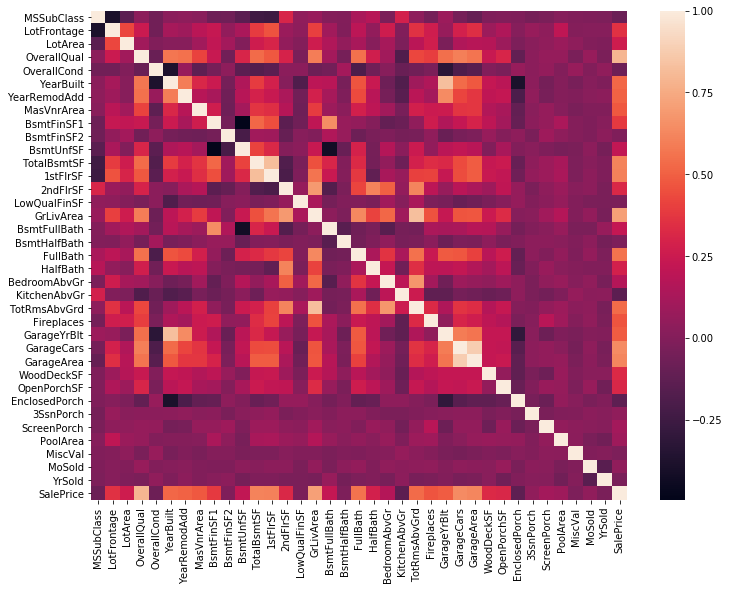

In [20]:
fig = plt.figure(figsize=(12,9))
sns.heatmap(train.corr())

In [21]:
imp_feat=abs(train.corr()['SalePrice']).sort_values(ascending=False).head(11).index

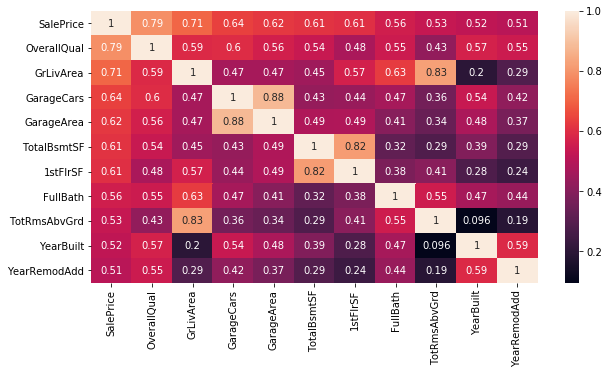

In [22]:
fig = plt.figure(figsize=(10,5))
sns.heatmap(train[imp_feat].corr(),annot=True)

GarageCars and GarageArea very correlated --> keep GarageCars

TotalBsmtSF and 1stFlrSF very correlated --> keep TotalBsmtSF

GrLivArea and TotRmsAbvGrd very correlated --> keep GrLivArea

In [23]:
imp_feat_2 = imp_feat.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd'])

In [24]:
imp_feat_2

Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
       'FullBath', 'YearBuilt', 'YearRemodAdd'],
      dtype='object')

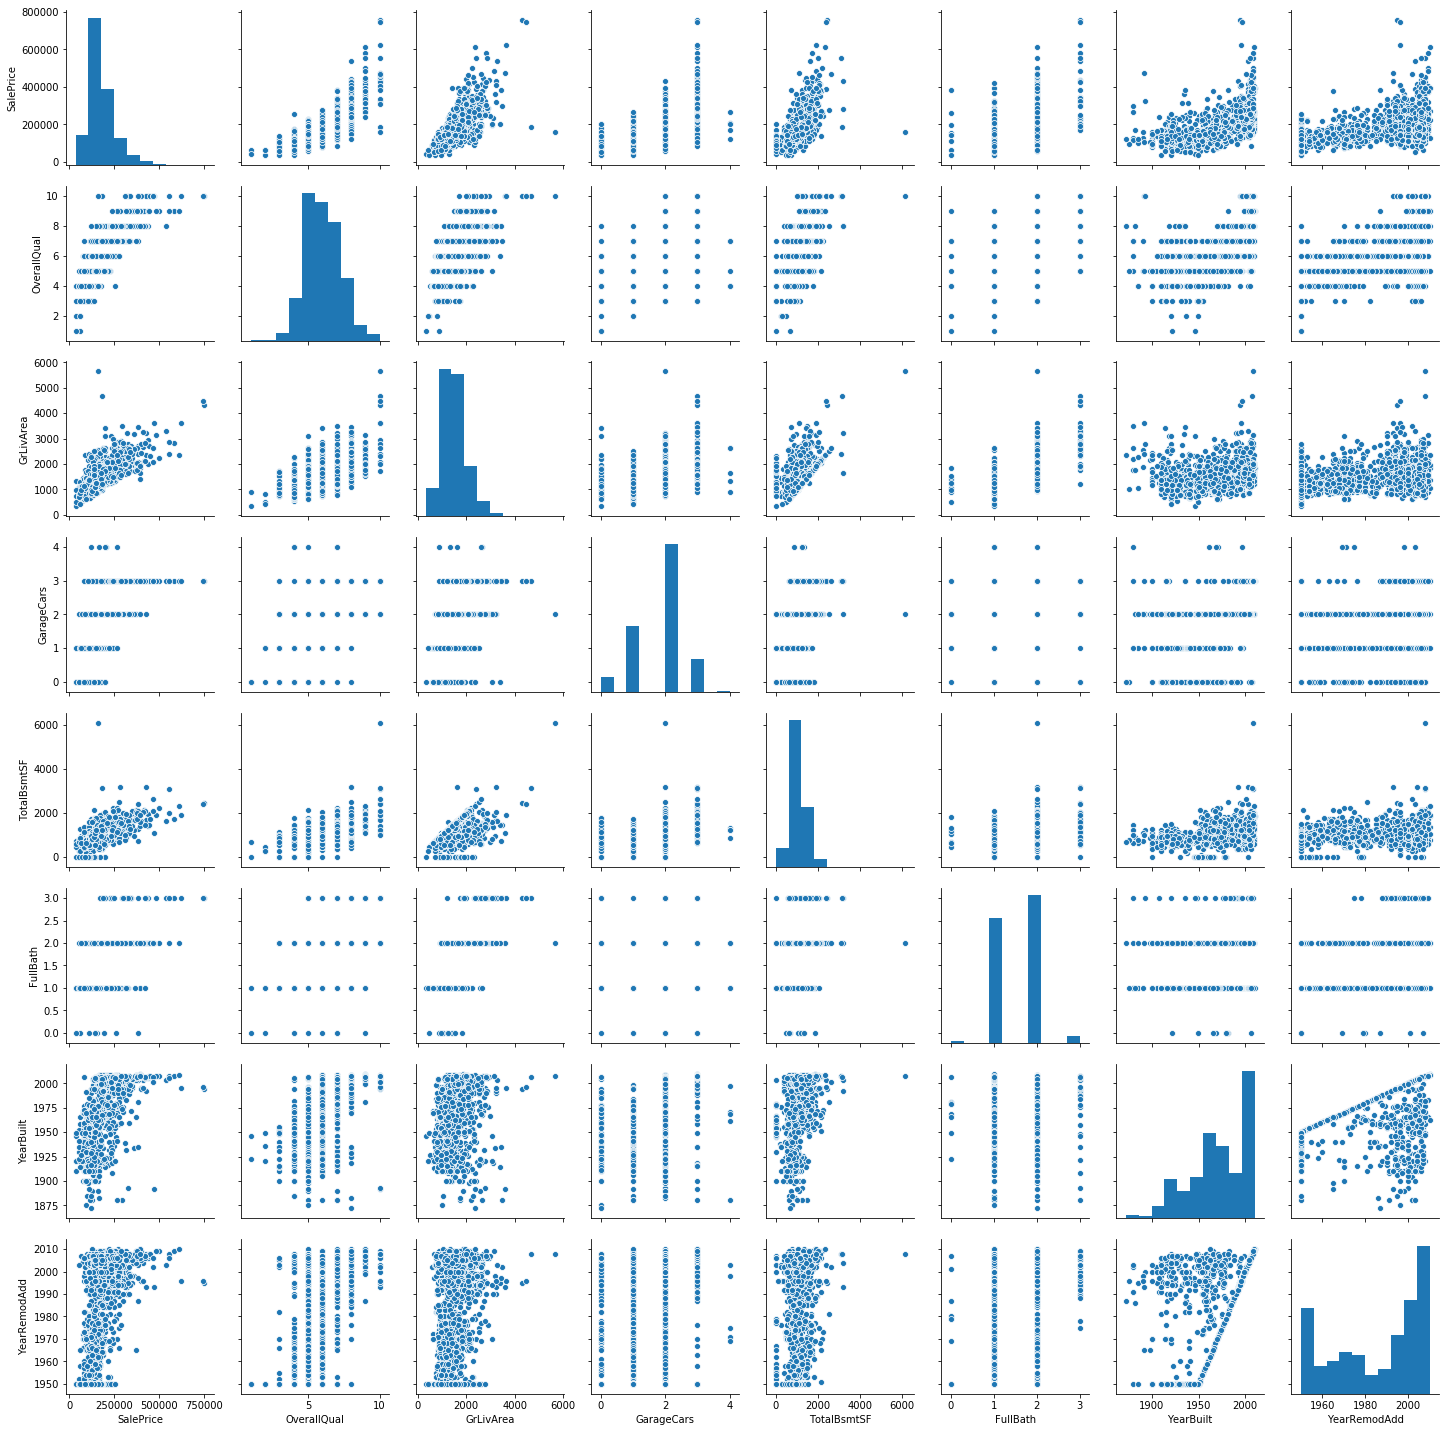

In [25]:
sns.pairplot(train[imp_feat_2])

## Outliars

We first see form the pairplot two outliars in SalePrice vs GrLivArea, let's identify and eliminate those

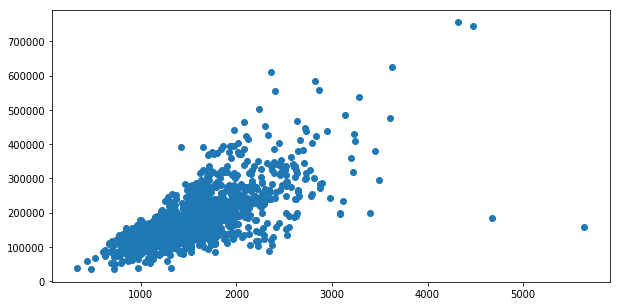

In [26]:
fig = plt.figure(figsize=(10,5))
plt.scatter(x=train.GrLivArea,y=train.SalePrice)

In [27]:
#train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
#all_data = all_data.drop(all_data[(all_data['GrLivArea']>4000) & (all_data['SalePrice']<300000)].index)

In [28]:
#fig = plt.figure(figsize=(10,5))
#plt.scatter(x=train.GrLivArea,y=train.SalePrice)

## Normalising Features and Target

In [29]:
x=abs(train[imp_feat_2].skew()).sort_values(ascending=False)
x

SalePrice       1.882876
TotalBsmtSF     1.524255
GrLivArea       1.366560
YearBuilt       0.613461
YearRemodAdd    0.503562
GarageCars      0.342549
OverallQual     0.216944
FullBath        0.036562
dtype: float64

In [30]:
def check_skew(column,with_log):
    feat = train[column]
    if (with_log==False):
        fig,ax = plt.subplots(figsize = (5,3))
        ax = sns.distplot(feat,fit=norm)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = stats.probplot(feat, plot=plt)
        (mu, sigma) = norm.fit(feat)
        print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    elif (with_log==True):
        feat = np.log1p(feat)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = sns.distplot(feat,fit=norm)
        fig,ax = plt.subplots(figsize = (5,3))
        ax = stats.probplot(feat, plot=plt)
        (mu, sigma) = norm.fit(feat)
        print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    

The normal dist fit has the following parameters: 
 mu = 180921.20 and sigma = 79415.29

The normal dist fit has the following parameters: 
 mu = 12.02 and sigma = 0.40



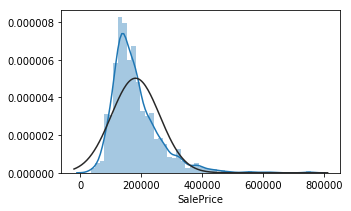

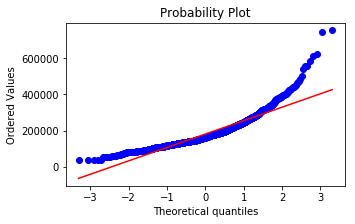

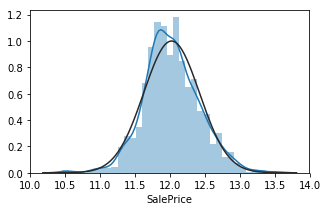

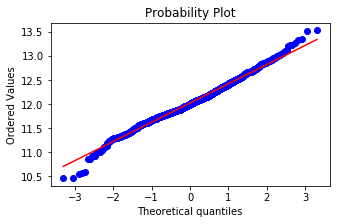

In [31]:
check_skew(column='SalePrice',with_log=False)
check_skew(column='SalePrice',with_log=True)

In [32]:
train['SalePrice'] = np.log1p(train['SalePrice'])

The normal dist fit has the following parameters: 
 mu = 1057.43 and sigma = 438.56

The normal dist fit has the following parameters: 
 mu = 6.75 and sigma = 1.15



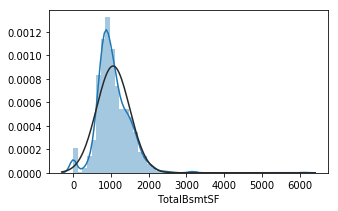

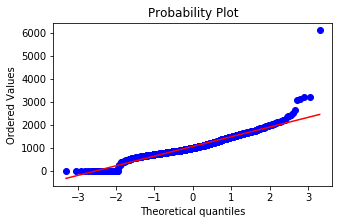

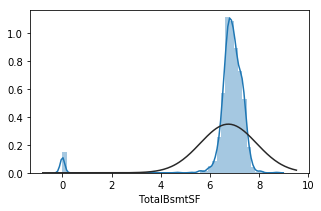

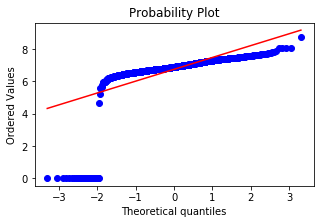

In [33]:
check_skew(column='TotalBsmtSF',with_log=False)
check_skew(column='TotalBsmtSF',with_log=True)

Zero values ruin log method, must not include them in log

In [34]:
all_data['TotalBsmtSF'][all_data['TotalBsmtSF']!=0] =  np.log1p(all_data['TotalBsmtSF'][all_data['TotalBsmtSF']!=0])

/Users/pol.molinas/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


The normal dist fit has the following parameters: 
 mu = 1084.92 and sigma = 409.27



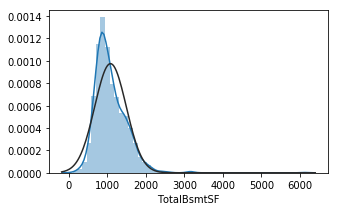

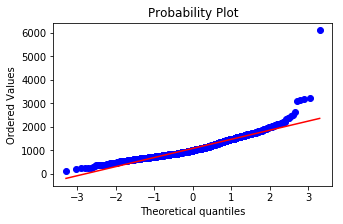

In [35]:
fig,ax = plt.subplots(figsize = (5,3))
ax = sns.distplot(train['TotalBsmtSF'][train['TotalBsmtSF']!=0],fit=norm)
fig,ax = plt.subplots(figsize = (5,3))
ax = stats.probplot(train['TotalBsmtSF'][train['TotalBsmtSF']!=0], plot=plt)
(mu, sigma) = norm.fit(train['TotalBsmtSF'][train['TotalBsmtSF']!=0])
print( 'The normal dist fit has the following parameters: \n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

In [36]:
x=abs(train[imp_feat_2].skew()).sort_values(ascending=False)
x

TotalBsmtSF     1.524255
GrLivArea       1.366560
YearBuilt       0.613461
YearRemodAdd    0.503562
GarageCars      0.342549
OverallQual     0.216944
SalePrice       0.121347
FullBath        0.036562
dtype: float64

In [37]:
all_data = pd.get_dummies(all_data)

In [38]:
all_data.shape

(2919, 294)

# Modelling

In [39]:
y_train = train.SalePrice
train = all_data[:ntrain]
test = all_data[ntrain:]

In [40]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC, LogisticRegression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb

In [41]:
X = train
y = y_train

In [42]:
X.shape

(1460, 294)

In [43]:
y.shape

(1460,)

In [44]:
test.shape

(1459, 294)

In [45]:
gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.5, random_state=1,max_iter=5000))

In [46]:
def cross_val(model):
    kf = KFold(n_splits=5,random_state=42,shuffle=True)
    return(np.sqrt(-cross_val_score(model,X,y,scoring='neg_mean_squared_error',cv=kf)).mean())

In [47]:
cross_val(lasso)

0.37247163148126805

In [48]:
cross_val(gb)

0.12539746213382572

In [49]:
gb.fit(X,y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='huber', max_depth=4,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=15, min_samples_split=10,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=5,
             subsample=1.0, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [50]:
mean_squared_error(gb.predict(X),y)

0.0034053361255405538

In [53]:
sub = pd.DataFrame()
sub['Id'] = test_ID
sub['SalePrice'] = np.expm1(gb.predict(test))
sub.to_csv('submission.csv',index=False)